<a href="https://colab.research.google.com/github/SantiCusse/Pre-Entrega-Proyecto-Santiago-Cusse-Peschiera/blob/main/Validacion_de_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Refugio de animales

Siempre me llamó la atención el abandono de mascotas. Cómo el ser humano puede ser tan inhumano a la hora de tratar con otras especies y sobretodo con animales que decidieron incorporar a su familia. El abandono puede no ser la única razón o puede no ser la más probable. Por otro lado es interesante analizar qué animales ingresan al refugio y la edad de los mismos.
Teniendo en cuenta estas variables se pueden tomar acciones para la construcción de nuevos refugios, tanto en dimensión como en recursos necesarios para darle tratamiento a las necesidades de los animales.
También me genera inquietud saber como los refugios gestionan los ingresos y salidas de animales ya que hay que tener en cuenta un monton de factores para poder sostener económicamente un establecimiento de este tipo.
Para este análisis encontrè una base de datos con 31600 registros de un refugio ubicado en una ciudad norteamericana de 85.000 habitantes llamada Bloomington.

In [ ]:
!pip install sodapy
!pip install catboost

In [ ]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sodapy import Socrata
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
client = Socrata("data.bloomington.in.gov", None)

results = client.get("e245-r9ub", limit=100000)

df = pd.DataFrame.from_records(results)

A continuación podemos ver la información que contiene el dataset sobre el cual se hizo el análisis

In [ ]:
titles_df = pd.DataFrame(df.columns, columns=['Información'])
print(titles_df)

         Información
0                 id
1         intakedate
2       intakereason
3         istransfer
4        sheltercode
5   identichipnumber
6         animalname
7          breedname
8         basecolour
9        speciesname
10         animalage
11           sexname
12          location
13      movementdate
14      movementtype
15           istrial
16    returnedreason
17    deceasedreason
18    diedoffshelter
19        puttosleep
20             isdoa
21        returndate
22      deceaseddate


In [ ]:
#Revisamos cantidad de filas y columnas
df.shape

(33239, 23)

In [ ]:
df.head()

,id,intakedate,intakereason,istransfer,sheltercode,identichipnumber,animalname,breedname,basecolour,speciesname,...,movementdate,movementtype,istrial,returnedreason,deceasedreason,diedoffshelter,puttosleep,isdoa,returndate,deceaseddate
0,15801,2009-11-28T00:00:00.000,Moving,False,C09115463,0A115D7358,Jadzia,Domestic Short Hair,Tortoiseshell,Cat,...,2017-05-13T00:00:00.000,Adoption,False,Stray,Died in care,False,False,False,NaN,NaN
1,15932,2009-12-08T00:00:00.000,Moving,False,D09125594,0A11675477,Gonzo,German Shepherd Dog/Mix,Tan,Dog,...,2017-04-24T00:00:00.000,Adoption,False,Stray,Died in care,False,False,False,NaN,NaN
2,28859,2012-08-10T00:00:00.000,Abandoned,False,D23111515,0A13253C7B,Maggie,Shep Mix/Siberian Husky,Black and Tan,Dog,...,2017-04-15T00:00:00.000,Adoption,False,Stray,Died in care,False,False,False,2020-02-28T00:00:00.000,NaN
3,28859,2012-08-10T00:00:00.000,Abandoned,False,D23111515,0A13253C7B,Maggie,Shep Mix/Siberian Husky,Black and Tan,Dog,...,2020-02-29T00:00:00.000,Reclaimed,False,Stray,Died in care,False,False,False,2023-11-06T00:00:00.000,NaN
4,28859,2012-08-10T00:00:00.000,Abandoned,False,D23111515,0A13253C7B,Maggie,Shep Mix/Siberian Husky,Black and Tan,Dog,...,2023-12-17T00:00:00.000,Adoption,False,Stray,Died in care,False,False,False,NaN,NaN


Antes de empezar a hacer el análisis tenemos que hacer una limpieza del dataset. En primer lugar vamos a ver qué columnas tienen datos nulos y su cantidad. Además vamos a eliminar las columnas que consideramos que no aportan información valiosa.

In [ ]:
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

intakereason            2
identichipnumber     4024
breedname              72
movementdate         5353
returndate          23001
deceaseddate        32266
dtype: int64


In [ ]:
df.dtypes

id                  object
intakedate          object
intakereason        object
istransfer            bool
sheltercode         object
identichipnumber    object
animalname          object
breedname           object
basecolour          object
speciesname         object
animalage           object
sexname             object
location            object
movementdate        object
movementtype        object
istrial               bool
returnedreason      object
deceasedreason      object
diedoffshelter        bool
puttosleep            bool
isdoa                 bool
returndate          object
deceaseddate        object
dtype: object

In [ ]:
#Elimino Columnas que no me aportan información y las que tienen muchos registros nulos
df = df.drop(columns=['returndate'])
df = df.drop(columns=['deceaseddate'])
df = df.drop(columns=['identichipnumber'])

#Elimino los registros con datos nulos
df = df.dropna(subset=['intakereason'])
df = df.dropna(subset=['breedname'])
df = df.dropna(subset=['basecolour'])



In [ ]:
#Convierto el campo 'movementdate' a tipo fecha y me quedo solo con la parte de la fecha, sin la hora
df['movementdate'] = pd.to_datetime(df['movementdate'])

df['movementdate'] = df['movementdate'].dt.date


<ipython-input-57-8eda125a703a>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


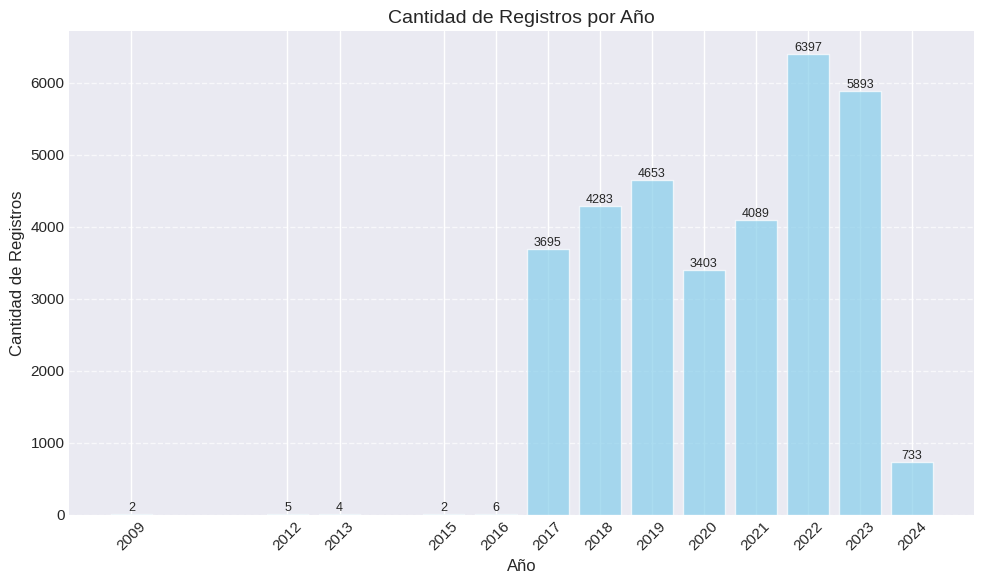

In [ ]:
# Convertir la columna 'intakedate' al formato de fecha si no está en ese formato
df['intakedate'] = pd.to_datetime(df['intakedate'])

# Extraer el año de la columna 'intakedate'
df['year'] = df['intakedate'].dt.year

# Contar la cantidad de registros por año
records_per_year = df['year'].value_counts().sort_index()

# Gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-darkgrid')

# Crear el gráfico de barras
bars = plt.bar(records_per_year.index, records_per_year.values, color='skyblue', alpha=0.7)

# Añadir etiquetas, título y ajustes visuales
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Registros', fontsize=12)
plt.title('Cantidad de Registros por Año', fontsize=14)
plt.xticks(records_per_year.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar valores en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
#Tomo los datos de 2017 en adelante ya que anterior a ese año tenemos muy pocos datos
df = df[(df['year'] >2016)].copy()
#Elimino registros duplicados
df.drop_duplicates(inplace=True)

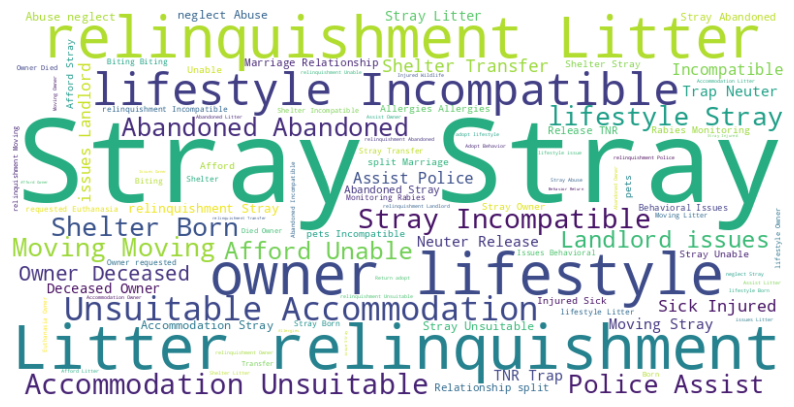

In [ ]:
from wordcloud import WordCloud
# Unir todas las palabras en la columna 'intakereason'
text = ' '.join(df['intakereason'].dropna().astype(str))

# Crear un objeto WordCloud con un tamaño de fuente máxima según la frecuencia
wordcloud = WordCloud(width=800, height=400, max_font_size=150, background_color='white').generate(text)

# Mostrar la imagen de la nube de palabras
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Por otro lado hacemos el análisis de los outliers, principalmente sobre la edad de los animales que es un punto importante para nuestro informe. En general tenemos muy pocos registros por encima de los 30 años de edad y pensando en la edad posible de una mascota, es muy raro encontrar animales tan longevos. es por eso que estos registros los voy a excluir del análisis.

In [ ]:
#No me interesa saber en detalle la cantidad de meses que tiene el animal, por lo tanto si tiene meses o semanas lo reemplazo por 0 que se va a interpretar como que tiene menos de 1 año.
df['animalage'] = df['animalage'].apply(lambda x: '0 ' if 'year' not in str(x) else x)
# Separo el campo a partir del primer espacio y me quedo con el primer valor que corresponde a la cantidad de años
df['animalage'] = df['animalage'].str.split().str[0]
# Transformo a tipo numérico
df['animalage'] = pd.to_numeric(df['animalage'], errors='coerce')

<ipython-input-61-44bce6bb24e6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y='animalage', palette='Set1')


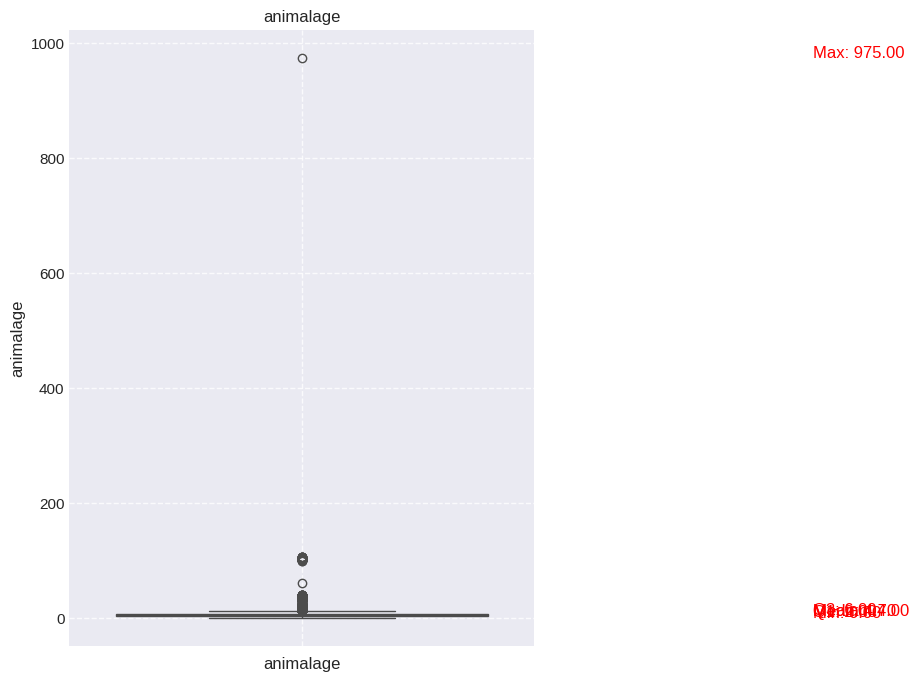

In [ ]:
plt.figure(figsize=(6, 8))
sns.boxplot(data=df, y='animalage', palette='Set1')

plt.title('animalage')
plt.xlabel('animalage')
plt.grid(True, linestyle='--', alpha=0.8)

# Calculo estadisticos
age_stats = df['animalage'].describe()
# Marco los valores en el gráfico
plt.text(1.1, age_stats['max'], f'Max: {age_stats["max"]:.2f}', fontsize=12, color='red')
plt.text(1.1, age_stats['min'], f'Min: {age_stats["min"]:.2f}', fontsize=12, color='red')
plt.text(1.1, age_stats['25%'], f'Q1: {age_stats["25%"]:.2f}', fontsize=12, color='red')
plt.text(1.1, age_stats['50%'], f'Median: {age_stats["50%"]:.2f}', fontsize=12, color='red')
plt.text(1.1, age_stats['75%'], f'Q3: {age_stats["75%"]:.2f}', fontsize=12, color='red')
plt.text(1.1, age_stats['mean'], f'Mean: {age_stats["mean"]:.2f}', fontsize=12, color='red')

plt.show()

In [ ]:
# Calculo de percentiles e IQR
percentile25 = df['animalage'].quantile(0.25)
percentile75 = df['animalage'].quantile(0.75)
iqr = percentile75 - percentile25

# Calculo de límites
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Busco los outliers
outliers_above = df[df['animalage'] > upper_limit][['animalage', 'speciesname']]
outliers_below = df[df['animalage'] < lower_limit][['animalage', 'speciesname']]

In [ ]:
#Analizo los outliers_above
outliers_above_20 = outliers_above[outliers_above['animalage'] > 30]
outliers_above_20_sorted = outliers_above_20.sort_values(by='animalage')
print(outliers_above_20_sorted)

       animalage speciesname
14893         31         Cat
13199         31         Dog
12254         31         Cat
10386         31         Dog
12736         31         Cat
...          ...         ...
649          105        Bird
2156         105         Cat
927          105         Cat
1962         105         Cat
1747         975         Cat

[105 rows x 2 columns]


In [ ]:
# Excluyo los outliers analizados que sean maypres a 22 años ya que es raro que estos animales tengan mas de 30 años
# Los outliers_below no los elimino ya que son los que tienen edad entre 0 y 1 año
df2 = df[(df['animalage'] <30 )].copy()

Con el dataset limpio podemos empezar a hacer distintos análisis de los parametros que tenemos registrados.
En primer lugar me interesa saber qué animales son los que ingresan en mayor cantidad. Intuyo que deben ser perros y gatos pero puede haber algún otro tipo de animal que presente una cantidad considerable de ingresos y amerite su inclusión en el análisis posterior.

<ipython-input-65-ca8749bb739e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=filtered_df, x='speciesname', palette='Set2', order=filtered_df['speciesname'].value_counts().index)  # Personalizar paleta de colores y orden de barras


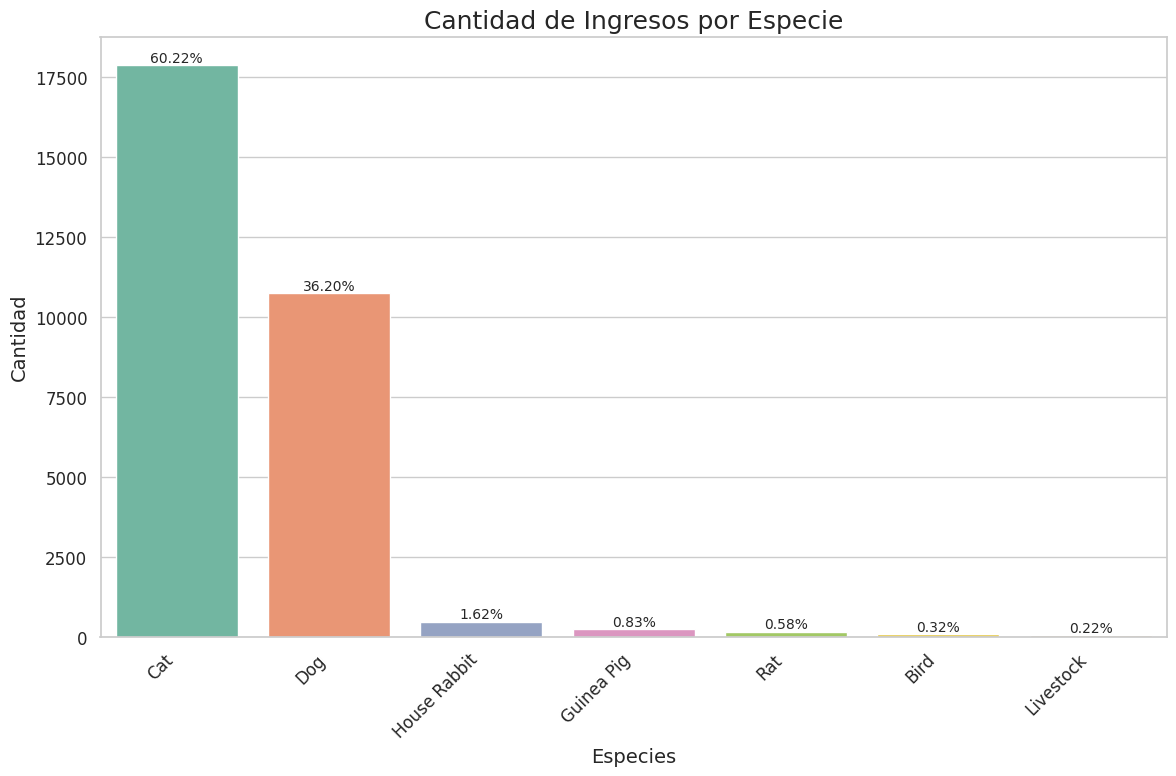

In [ ]:
speciesname_counts = df2['speciesname'].value_counts()
speciesname_more_than_10 = speciesname_counts[speciesname_counts > 50].index.tolist()

filtered_df = df2[df2['speciesname'].isin(speciesname_more_than_10)]

filtered_df_counts = filtered_df['speciesname'].value_counts()

plt.figure(figsize=(12, 8))  # Ajustar tamaño del gráfico para mejor visualización
sns.set(style="whitegrid", font_scale=1.2)  # Cambiar estilo a whitegrid y ajustar tamaño de fuente

ax = sns.countplot(data=filtered_df, x='speciesname', palette='Set2', order=filtered_df['speciesname'].value_counts().index)  # Personalizar paleta de colores y orden de barras
ax.set_title('Cantidad de Ingresos por Especie', fontsize=18)  # Añadir un título al gráfico
ax.set_xlabel('Especies', fontsize=14)  # Etiqueta del eje x
ax.set_ylabel('Cantidad', fontsize=14)  # Etiqueta del eje y

# Rotar etiquetas del eje x para mejor legibilidad y ajustar espacio
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Añadir porcentaje en las barras
total = float(len(filtered_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 3,
            f'{(height / total * 100):.2f}%',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Ajustar diseño del gráfico
plt.show()

Claramente tenemos mayoría de gatos y perros pero con una llamativa superioridad de los gatos sobre los perros. Por otro lado aparecen los conejos, ratas, pájaros y cerdos como los más ingresados pero en cantidades muy inferiores a los primeros dos del podio.

Vamos a analizar un poco más en detalle las características de los perros y los gatos que ingresan al refugio. Para esto podemos armar un boxplot de la edad de dichos animales. Los analizamos por separado ya que tanto el comportamiento como la longevidad de los mismos es distinta.

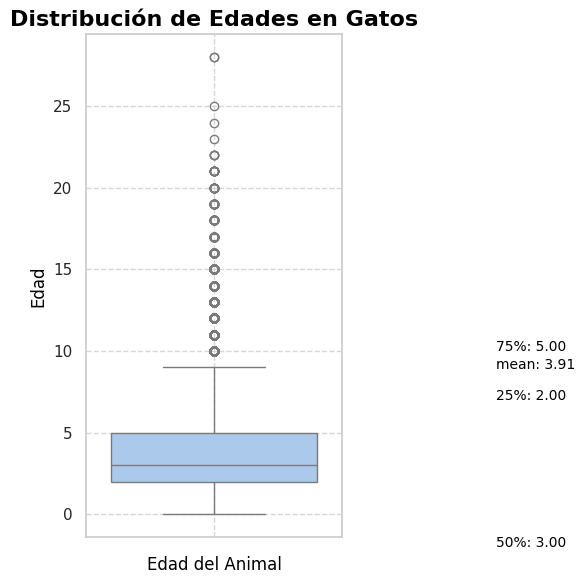

In [ ]:
cat_data = df2[df2['speciesname'] == 'Cat']

plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
sns.set(style="whitegrid", palette="pastel")  # Cambiar estilo y paleta de colores

sns.boxplot(data=cat_data, y='animalage')

plt.title('Distribución de Edades en Gatos', fontsize=16, fontweight='bold', color='black')  # Título
plt.xlabel('Edad del Animal', fontsize=12, color='black')  # Etiqueta del eje x
plt.ylabel('Edad', fontsize=12, color='black')  # Etiqueta del eje y
plt.grid(True, linestyle='--', alpha=0.8)

# Mostrar medidas estadísticas en el gráfico con tamaño y color definidos
age_stats = cat_data['animalage'].describe()
for stat, y_pos, offset in zip(['25%', '50%', '75%', 'mean'],
                               [age_stats['25%'], age_stats['50%'], age_stats['75%'], age_stats['mean']],
                               [5, -5, 5, 5]):
    plt.text(1.1, y_pos + offset, f'{stat}: {y_pos:.2f}', fontsize=10, color='black')  # Ajuste de la posición

plt.tight_layout()  # Ajustar diseño del gráfico
plt.show()

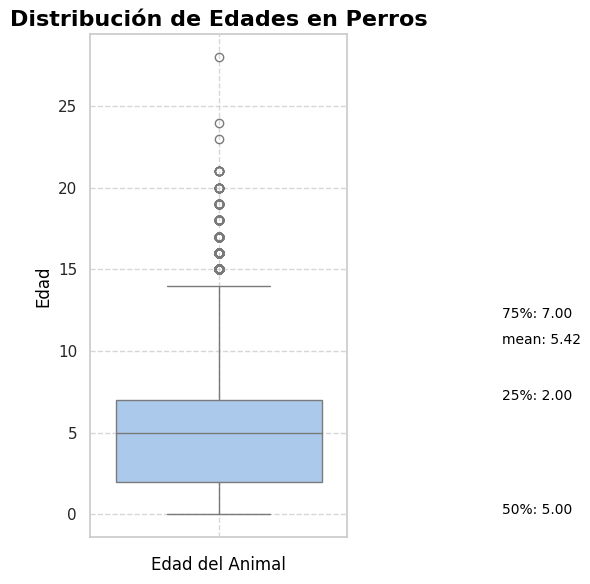

In [ ]:
cat_data = df2[df2['speciesname'] == 'Dog']

plt.figure(figsize=(8, 6))  # Ajustar tamaño del gráfico
sns.set(style="whitegrid", palette="pastel")  # Cambiar estilo y paleta de colores

sns.boxplot(data=cat_data, y='animalage')

plt.title('Distribución de Edades en Perros', fontsize=16, fontweight='bold', color='black')  # Título
plt.xlabel('Edad del Animal', fontsize=12, color='black')  # Etiqueta del eje x
plt.ylabel('Edad', fontsize=12, color='black')  # Etiqueta del eje y
plt.grid(True, linestyle='--', alpha=0.8)

# Mostrar medidas estadísticas en el gráfico con tamaño y color definidos
age_stats = cat_data['animalage'].describe()
for stat, y_pos, offset in zip(['25%', '50%', '75%', 'mean'],
                               [age_stats['25%'], age_stats['50%'], age_stats['75%'], age_stats['mean']],
                               [5, -5, 5, 5]):
    plt.text(1.1, y_pos + offset, f'{stat}: {y_pos:.2f}', fontsize=10, color='black')  # Ajuste de la posición

plt.tight_layout()  # Ajustar diseño del gráfico
plt.show()


Podemos ver que hay una diferencia en interesante en la edad media que tienen estos animales al momento de ingresar al refugio. Si bien los gatos en buenas condiciones viven más que los perros, vemos que ingresan al refugio a una edad más temprana. En ambos casos el promedio ingresa por encima de los 3 años de edad por lo cual se puede decir que ya son animales adultos.

Ahora que entendemos un poco más sobre la característica de los aniamles que ingresan, vamos a estudiar las razones por las que ingresan. En primer lugar listamos todas las razones que podemos encontrar en el dataset y luego hacemos foco en las más comunes para sacar conclusiones.

In [ ]:

filtered_intakereason_sorted = filtered_df_counts.sort_values(ascending=False)

total_count = filtered_intakereason_sorted.sum()

for intakereason, count in filtered_intakereason_sorted.items():
    percentage = (count / total_count) * 100
    print(f"intakereason: {intakereason}, Count: {count}, Percentage: {percentage:.2f}%")

intakereason: Cat, Count: 17867, Percentage: 60.22%
intakereason: Dog, Count: 10741, Percentage: 36.20%
intakereason: House Rabbit, Count: 481, Percentage: 1.62%
intakereason: Guinea Pig, Count: 247, Percentage: 0.83%
intakereason: Rat, Count: 172, Percentage: 0.58%
intakereason: Bird, Count: 96, Percentage: 0.32%
intakereason: Livestock, Count: 65, Percentage: 0.22%


<ipython-input-69-16bfb3e5be51>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=filtered_df, x='intakereason', order=filtered_df['intakereason'].value_counts().index, palette='pastel')


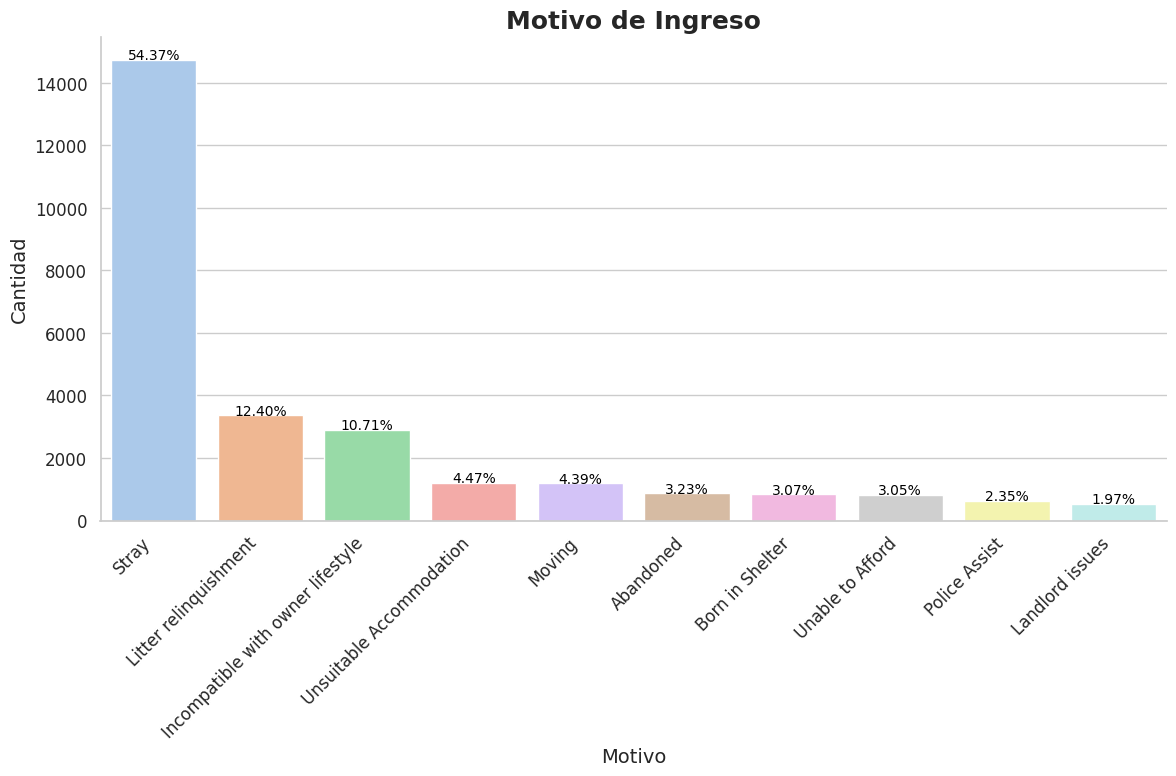

In [ ]:
intakereason_counts = df2['intakereason'].value_counts()
intakereason_more_than_10 = intakereason_counts[intakereason_counts > 500].index.tolist()

filtered_df = df2[df2['intakereason'].isin(intakereason_more_than_10)]

filtered_df_counts = filtered_df['intakereason'].value_counts()

plt.figure(figsize=(12, 8))  # Ajustar tamaño del gráfico para mejor visualización
sns.set(style="whitegrid", font_scale=1.2)  # Cambiar estilo a whitegrid y ajustar tamaño de fuente

ax = sns.countplot(data=filtered_df, x='intakereason', order=filtered_df['intakereason'].value_counts().index, palette='pastel')

total_valores = len(filtered_df)

for i, count in enumerate(filtered_df['intakereason'].value_counts()):
    porcentaje = (count / total_valores) * 100
    plt.text(i, count + 5, f'{porcentaje:.2f}%', ha='center', fontsize=10, color='black')

ax.set_xlabel('Motivo', fontsize=14)
ax.set_ylabel('Cantidad', fontsize=14)
ax.set_title('Motivo de Ingreso', fontsize=18, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

A continuación vemos cuales son las 5 principales razones por las que los animales ingresan al refugio. Podemos observar un dato muy interesante que es que el 50% de los ingresos se deben a que los animales se pierden. En segundo lugar tenemos al abandono que acumula aproximadamente un 30% de los casos (Se consideraron casos de abandono a :
-Litter relinquishment
-Incompatible with owner lifestyle
-Moving)

A continuación vamos a calcular la cantidad de días promedio que un animal puede estar en el refugio. Además podríamos ver como distribuyen los datos para entender los valores máximos y mínimos que se manejan en un refugio de estas caracterìsticas.

In [ ]:
from datetime import datetime

df2['intakedate'] = pd.to_datetime(df2['intakedate'])
df2['movementdate'] = pd.to_datetime(df2['movementdate'])


df2['movementdate'].fillna(pd.to_datetime(datetime.today().date()), inplace=True)

df2['date_difference'] = (df2['movementdate'] - df2['intakedate']).dt.days

df2['date_difference'] = df2['date_difference'].mask(df2['date_difference'] < 0, 0)

print(df2)

          id          intakedate intakereason  istransfer sheltercode  \
19     47120 2017-01-11 00:00:00    Abandoned       False   C17011137   
20     47120 2017-01-11 00:00:00    Abandoned       False   C17011137   
21     47146 2017-01-17 00:00:00    Abandoned       False   D17011163   
22     47146 2017-01-17 00:00:00    Abandoned       False   D17011163   
23     47156 2017-01-17 00:00:00    Abandoned       False   R17011173   
...      ...                 ...          ...         ...         ...   
33234  79430 2024-03-14 15:10:22        Stray       False    C2403318   
33235  79431 2024-03-14 15:10:22        Stray       False    C2403319   
33236  79434 2024-03-15 12:02:01        Stray       False    D2403320   
33237  79439 2024-03-15 15:18:22        Stray       False    C2403323   
33238  79454 2024-03-17 14:07:26        Stray       False    D2403327   

           animalname                         breedname       basecolour  \
19             Vivian                         H

In [ ]:
# Calcula los límites para los outliers
q1 = df2['date_difference'].quantile(0.25)
q3 = df2['date_difference'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtra el DataFrame original para crear uno nuevo sin outliers y solo con 'Cat' o 'Dog'
df3 = df2[
    (df2['date_difference'] >= lower_bound) & (df2['date_difference'] <= upper_bound) &
    (df2['speciesname'].isin(['Cat', 'Dog']))
].copy()

# Verifica el nuevo DataFrame sin outliers y solo con 'Cat' o 'Dog'
print(df3)

          id          intakedate intakereason  istransfer sheltercode  \
19     47120 2017-01-11 00:00:00    Abandoned       False   C17011137   
20     47120 2017-01-11 00:00:00    Abandoned       False   C17011137   
21     47146 2017-01-17 00:00:00    Abandoned       False   D17011163   
22     47146 2017-01-17 00:00:00    Abandoned       False   D17011163   
28     47198 2017-01-22 00:00:00    Abandoned       False   C17011213   
...      ...                 ...          ...         ...         ...   
33234  79430 2024-03-14 15:10:22        Stray       False    C2403318   
33235  79431 2024-03-14 15:10:22        Stray       False    C2403319   
33236  79434 2024-03-15 12:02:01        Stray       False    D2403320   
33237  79439 2024-03-15 15:18:22        Stray       False    C2403323   
33238  79454 2024-03-17 14:07:26        Stray       False    D2403327   

           animalname                         breedname       basecolour  \
19             Vivian                         H

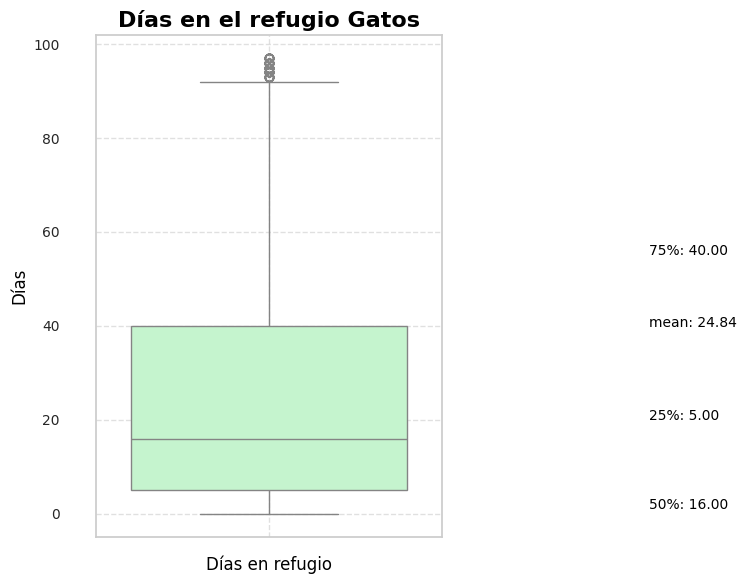

In [ ]:

cat_data_dias = df3[df3['speciesname'] == 'Cat']
plt.figure(figsize=(10, 6))  # Ajustar tamaño del gráfico
custom_palette = sns.color_palette(['#BDFCC9', '#98FB98', '#7FFFD4', '#66CDAA', '#20B2AA'])  # Definir una paleta de verdes claros
sns.set(style="whitegrid", palette=custom_palette)  # Establecer estilo y paleta de colores



# Filtrar outliers para el gráfico de caja
q1 = cat_data_dias['date_difference'].quantile(0.25)
q3 = cat_data_dias['date_difference'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_df_cat = cat_data_dias[(cat_data_dias['date_difference'] >= lower_bound) & (cat_data_dias['date_difference'] <= upper_bound)]

sns.boxplot(data=filtered_df_cat, y='date_difference')

plt.title('Días en el refugio Gatos', fontsize=16, fontweight='bold', color='black')  # Título más claro y en negrita
plt.xlabel('Días en refugio', fontsize=12, color='black')  # Etiqueta del eje x
plt.ylabel('Días', fontsize=12, color='black')  # Etiqueta del eje y
plt.grid(True, linestyle='--', alpha=0.6)  # Reducir opacidad de la cuadrícula

# Mostrar medidas estadísticas en el gráfico con tamaño y color definidos
date_stats = filtered_df_cat['date_difference'].describe()
vertical_offsets = [15, -15, 15, 15]  # Ajuste vertical de las etiquetas
for stat, y_pos, offset in zip(['25%', '50%', '75%', 'mean'], [date_stats['25%'], date_stats['50%'], date_stats['75%'], date_stats['mean']], vertical_offsets):
    plt.text(1.1, y_pos + offset, f'{stat}: {y_pos:.2f}', fontsize=10, color='black')  # Ajuste de la posición

plt.tight_layout()  # Ajustar diseño del gráfico

# Ajustar espaciado entre los ticks del eje y
plt.yticks(fontsize=10)  # Tamaño de fuente
plt.gca().tick_params(axis='y', which='major', pad=20)  # Ajuste de espaciado entre los ticks del eje y

plt.show()

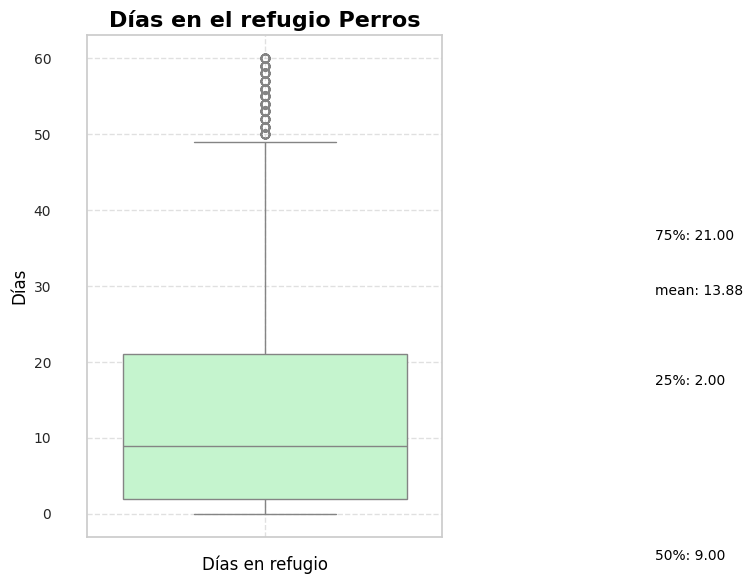

In [ ]:
Dog_data_dias = df3[df3['speciesname'] == 'Dog']

plt.figure(figsize=(10, 6))  # Ajustar tamaño del gráfico
custom_palette = sns.color_palette(['#BDFCC9', '#98FB98', '#7FFFD4', '#66CDAA', '#20B2AA'])  # Definir una paleta de verdes claros
sns.set(style="whitegrid", palette=custom_palette)  # Establecer estilo y paleta de colores

# Filtrar outliers para el gráfico de caja
q1 = Dog_data_dias['date_difference'].quantile(0.25)
q3 = Dog_data_dias['date_difference'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_df_dog = Dog_data_dias[(Dog_data_dias['date_difference'] >= lower_bound) & (Dog_data_dias['date_difference'] <= upper_bound)]

sns.boxplot(data=filtered_df_dog, y='date_difference')

plt.title('Días en el refugio Perros', fontsize=16, fontweight='bold', color='black')  # Título más claro y en negrita
plt.xlabel('Días en refugio', fontsize=12, color='black')  # Etiqueta del eje x
plt.ylabel('Días', fontsize=12, color='black')  # Etiqueta del eje y
plt.grid(True, linestyle='--', alpha=0.6)  # Reducir opacidad de la cuadrícula

# Mostrar medidas estadísticas en el gráfico con tamaño y color definidos
date_stats = filtered_df_dog['date_difference'].describe()
vertical_offsets = [15, -15, 15, 15]  # Ajuste vertical de las etiquetas
for stat, y_pos, offset in zip(['25%', '50%', '75%', 'mean'], [date_stats['25%'], date_stats['50%'], date_stats['75%'], date_stats['mean']], vertical_offsets):
    plt.text(1.1, y_pos + offset, f'{stat}: {y_pos:.2f}', fontsize=10, color='black')  # Ajuste de la posición

plt.tight_layout()  # Ajustar diseño del gráfico

# Ajustar espaciado entre los ticks del eje y
plt.yticks(fontsize=10)  # Tamaño de fuente
plt.gca().tick_params(axis='y', which='major', pad=20)  # Ajuste de espaciado entre los ticks del eje y

plt.show()

In [ ]:

max_date_difference = df3['date_difference'].max()

mean_date_difference = df3['date_difference'].mean()

print(f"Maximo de dias en refugio: {max_date_difference:.2f}")

print(f"Promedio general dias en refugio: {mean_date_difference}")

Maximo de dias en refugio: 130.00
Promedio general dias en refugio: 24.552434681710878


In [ ]:
df3.shape

(24993, 22)

Podemos observar que la cantidad de días promedio es de 24, es decir aproximadamente 1 mes.
Este es un dato sumamente importante porque a partir del mismo se pueden calcular los recursos necesarios para tener en funcionamiento el refugio. Además se puede tener bajo control la rotación de los animales revisando los casos que estan por encima de la estadía promedio para reforzar las medidas que se toman para encontrarles un hogar.

Vamos a seguir analizando el dataset pero solamente para las especies de Perro y Gato ya que estos abarcan más del 90% de los casos. Lo que nos interesa saber es qué variables nos explican la cantidad de días que un perro o un gato estàn en trànsito en el refugio. En base a esto, una vez ingresado un animal vamos a poder estimar la cantidad de días que va a ocupar un espacio, la cantidad de alimento y medicamentos que va a necesitar.

# Entrenando y Evaluando un modelo de Machine Learning

Vamos a entrenar un modelo de machine learning para predecir si un animal que ingresa al refugio va a estar más de 7 días en el mismo antes de ser adoptado. Esto nos va a servir como indicador si hay que realizar una campaña de publicidad especial para que el animal sea adoptado lo más rápido posible.
Ademàs vamos a agregar la variable Mes_Ingreso ya que puede ayudar a mejorar la predicciòn para casos nuevos.

In [ ]:
# Hago una correcciòn del campo sexname filtrando los valores que no son conocidos
df3 = df3[df3['sexname'] != 'Unknown']

# Filtro el dataframe para los casos de adopción concretados
df4 = df3[(df3['movementtype'] == 'Adoption')].copy()

# Agrega la nueva columna 'campaña_especial' basada en la condición
df4['campaña_especial'] = (df4['date_difference'] > 10).astype(int)

# Agrego una columna ' Mes de entrada al refugio'
df4['Mes_Ingreso'] = df['intakedate'].dt.month

Hacemos un analisis PCA para ver en qué procentaje explican las variables independientes 'x' a la variable dependiente Y (campaña_especial) y ver si podemos eliminar alguna variable. Para esto lo primero que hacemos es un label_encoder para transformar las cariables categóricas en numéricas.

In [ ]:
from sklearn.preprocessing import LabelEncoder
x4 = df4[['location','intakereason', 'breedname', 'basecolour', 'speciesname', 'animalage', 'sexname','Mes_Ingreso']]
y4 = df4['campaña_especial']

label_encoder = LabelEncoder()
x4['location'] = label_encoder.fit_transform(x4['location'])
x4['intakereason'] = label_encoder.fit_transform(x4['intakereason'])
x4['breedname'] = label_encoder.fit_transform(x4['breedname'])
x4['basecolour'] = label_encoder.fit_transform(x4['basecolour'])
x4['speciesname'] = label_encoder.fit_transform(x4['speciesname'])
x4['animalage'] = x4['animalage']
x4['sexname'] = label_encoder.fit_transform(x4['sexname'])
x4['Mes_Ingreso'] = x4['Mes_Ingreso']

X4=x4[['location','intakereason', 'breedname', 'basecolour', 'speciesname', 'animalage', 'sexname','Mes_Ingreso']]

<ipython-input-77-9beada021174>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x4['location'] = label_encoder.fit_transform(x4['location'])
<ipython-input-77-9beada021174>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x4['intakereason'] = label_encoder.fit_transform(x4['intakereason'])
<ipython-input-77-9beada021174>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Porcentaje de varianza explicada por cada componente
[0.17260614 0.13806969 0.12990616 0.12651995 0.11920106 0.11404738
 0.10694156 0.09270805]


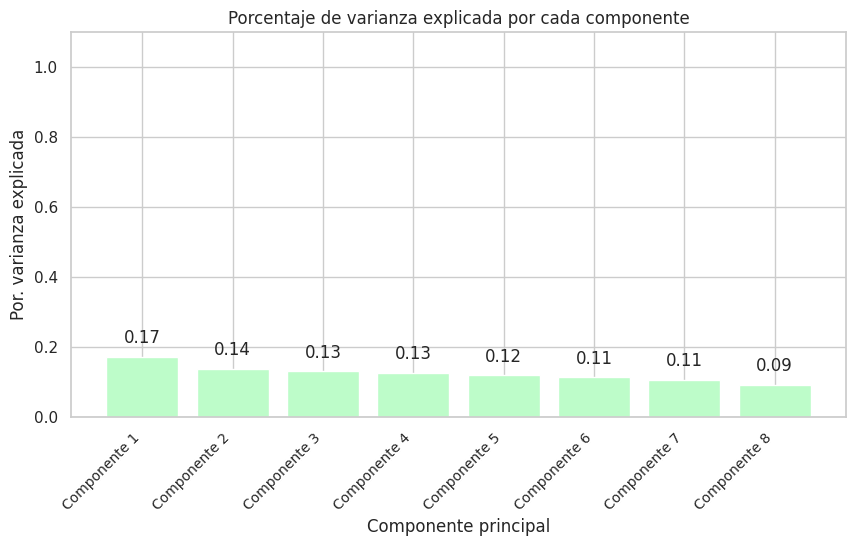

Cargas de las características en los componentes principales:
   intakereason      Raza  basecolour  speciesname  animalage   sexname  \
0      0.395211 -0.200051    0.364659     0.180351   0.601801  0.483047   
1      0.143542  0.108097    0.240872    -0.660088   0.063553 -0.139587   
2     -0.010962 -0.692968   -0.412888    -0.203171  -0.188159  0.127240   
3      0.571420 -0.000181   -0.490570     0.036754  -0.146589  0.289245   
4      0.219098  0.548647   -0.407607     0.263809   0.115040 -0.145282   
5      0.414706  0.221656    0.058112    -0.534511  -0.148267  0.051458   
6     -0.450708  0.343397   -0.076503    -0.169044  -0.147400  0.782643   
7      0.270998 -0.004814    0.471695     0.324431  -0.721083  0.105093   

   Mes_Ingreso  location  
0     0.059297 -0.198166  
1     0.667278  0.072062  
2     0.159122 -0.480632  
3     0.104365  0.561628  
4     0.289602 -0.545008  
5    -0.619043 -0.286292  
6     0.085362 -0.054490  
7     0.201601 -0.164735  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Entrenar un modelo de PCA
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(X4)

# Extraer el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

# Obtener las cargas de los componentes principales
loadings = modelo_pca.components_

# Crear un DataFrame para almacenar las cargas con los nombres de las características originales
loadings_df = pd.DataFrame(loadings, columns=xc.columns)

# Porcentaje de varianza explicada por cada componente
print('Porcentaje de varianza explicada por cada componente')
print(modelo_pca.explained_variance_ratio_)

# Crea un gráfico de barras para mostrar el porcentaje de varianza explicada
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
barplot = ax.bar(x=np.arange(modelo_pca.n_components_) + 1, height=modelo_pca.explained_variance_ratio_)

# Etiqueta el eje x con los nombres de las variables
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_xticklabels(['Componente ' + str(i) for i in range(1, modelo_pca.n_components_ + 1)], fontsize=10, rotation=45, ha='right')

# Anotar los valores en el gráfico
for i, y in enumerate(modelo_pca.explained_variance_ratio_, start=1):
    label = round(y, 2)
    ax.annotate(label, (i, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Configuración del gráfico
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')

# Mostrar el gráfico
plt.show()

# Mostrar las cargas de las características en un DataFrame
print("Cargas de las características en los componentes principales:")
print(loadings_df)

In [ ]:
from imblearn.over_sampling import SMOTE

# Aplica SMOTE para balancear las clases
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X4, y4)

# Crea un nuevo DataFrame df4_balanceado con las características y la variable objetivo balanceadas
df4_balanceado = pd.concat([pd.DataFrame(X_resampled, columns=X4.columns), pd.DataFrame(y_resampled, columns=['campaña_especial'])], axis=1)

# Muestra el nuevo DataFrame balanceado
print(df4_balanceado)

       location  intakereason  breedname  basecolour  speciesname  animalage  \
0            26             0        481          49            0          9   
1            26             0        541           1            1          8   
2            26             0        327           1            0         14   
3             1             0        362          18            0          8   
4             9             0        362          65            0         18   
...         ...           ...        ...         ...          ...        ...   
21689        33             6        362           1            0          6   
21690        19            14        676          74            1          9   
21691         2            19        350          37            0          5   
21692         3            19        362          42            0          4   
21693         5             7        783          17            1          5   

       sexname  Mes_Ingreso  campaña_es

In [ ]:
#Reviso como quedó balanceada la variable objetivo
conteo_campaña_especial = y_resampled.value_counts()

print(conteo_campaña_especial)

1    10847
0    10847
Name: campaña_especial, dtype: int64


In [ ]:
xb = df4_balanceado[['location','intakereason', 'breedname', 'basecolour', 'speciesname', 'animalage', 'sexname','Mes_Ingreso']]
yb = df4_balanceado['campaña_especial']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Suponiendo que tienes Xr como las características y yr como la variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(xb, yb, test_size=0.1, random_state=42)

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo Random Forest:", accuracy)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

Precisión del modelo Random Forest: 0.8253456221198157
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1056
           1       0.84      0.82      0.83      1114

    accuracy                           0.83      2170
   macro avg       0.83      0.83      0.83      2170
weighted avg       0.83      0.83      0.83      2170



Conclusiones:
Le agregamos una variable más 'Mes_Ingreso'la cual es el mes en la que el animal ingresa al refugio. Se agregó esta variable ya que podía ser una variable que influya en la cantidad de días que un animal permanezca en el refugio teniendo en cuenta que en determinados meses la actividad o las decisiones importantes que toman las personas disminuye, como por ejemplo en meses de vacaciones.
Como vemos en los resultados, lás métricas muestran una mejoría cercana al 5%, lo cual podemos decir que este nuevo modelo es superior al anterior para hacer predicciones.

#Evaluacion de modelos

Agrego una variable artificial 'Raza' que sea booleana. Si la columna breedname tiene la palabra 'domestic' no es de raza y toma el valor 1. Si es de Raza toma el valor 0. Hago esto porque creo que es una variable que puede influir significativamente en el resultado, es decir, en la cantidad de días que tarda un animal en ser adoptado.
Además vamos a probar dos modelos, Random Forest y Catboost para ver cual tiene mejor rendimiento a la hora de hacer predicciones. Luego hacemos análisis PCA sobre las variables utilizadas y seleccionar las más importantes.

In [ ]:
# Agrega la nueva columna 'campaña_especial' basada en la condición
df4['Raza'] = df4['breedname'].str.contains('Domestic').astype(int)

In [ ]:
from sklearn.preprocessing import LabelEncoder
x5 = df4[['location','intakereason', 'Raza', 'basecolour', 'speciesname', 'animalage', 'sexname','Mes_Ingreso']]
y5 = df4['campaña_especial']

label_encoder = LabelEncoder()
x5['location'] = label_encoder.fit_transform(x5['location'])
x5['intakereason'] = label_encoder.fit_transform(x5['intakereason'])
x5['Raza'] = label_encoder.fit_transform(x5['Raza'])
x5['basecolour'] = label_encoder.fit_transform(x5['basecolour'])
x5['speciesname'] = label_encoder.fit_transform(x5['speciesname'])
x5['animalage'] = x5['animalage']
x5['sexname'] = label_encoder.fit_transform(x5['sexname'])
x5['Mes_Ingreso'] = x5['Mes_Ingreso']

X5=x5[['location','intakereason', 'Raza', 'basecolour', 'speciesname', 'animalage', 'sexname','Mes_Ingreso']]

<ipython-input-84-0ef4613cf2c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x5['location'] = label_encoder.fit_transform(x5['location'])
<ipython-input-84-0ef4613cf2c9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x5['intakereason'] = label_encoder.fit_transform(x5['intakereason'])
<ipython-input-84-0ef4613cf2c9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [ ]:
from imblearn.over_sampling import SMOTE

# Aplica SMOTE para balancear las clases
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X5, y5)

# Crea un nuevo DataFrame df4_balanceado con las características y la variable objetivo balanceadas
df5_balanceado = pd.concat([pd.DataFrame(X_resampled, columns=X5.columns), pd.DataFrame(y_resampled, columns=['campaña_especial'])], axis=1)

# Muestra el nuevo DataFrame balanceado
print(df5_balanceado)

       location  intakereason  Raza  basecolour  speciesname  animalage  \
0            26             0     0          49            0          9   
1            26             0     0           1            1          8   
2            26             0     0           1            0         14   
3             1             0     1          18            0          8   
4             9             0     1          65            0         18   
...         ...           ...   ...         ...          ...        ...   
21689         5             7     0          32            1          6   
21690        23             7     0           4            0          3   
21691         1            19     1          64            0          0   
21692        20            19     0          18            1          5   
21693        18            19     0           1            1          1   

       sexname  Mes_Ingreso  campaña_especial  
0            0            1                 1  
1  

In [ ]:
#Reviso como quedó balanceada la variable objetivo
conteo_campaña_especial = y_resampled.value_counts()

print(conteo_campaña_especial)

1    10847
0    10847
Name: campaña_especial, dtype: int64


In [ ]:
xc = df5_balanceado[['intakereason', 'Raza', 'basecolour', 'speciesname', 'animalage', 'sexname','Mes_Ingreso','location']]
yc = df5_balanceado['campaña_especial']

In [ ]:
xc.head()

,intakereason,Raza,basecolour,speciesname,animalage,sexname,Mes_Ingreso,location
0,0,0,49,0,9,0,1,26
1,0,0,1,1,8,0,1,26
2,0,0,1,0,14,1,1,26
3,0,1,18,0,8,0,1,1
4,0,1,65,0,18,0,2,9


Aplicamos el modelo Random Forest y calculamos sus métricas

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Suponiendo que tienes Xr como las características y yr como la variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(xc, yc, test_size=0.1, random_state=42)

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo Random Forest:", accuracy)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

Precisión del modelo Random Forest: 0.8193548387096774
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1056
           1       0.84      0.80      0.82      1114

    accuracy                           0.82      2170
   macro avg       0.82      0.82      0.82      2170
weighted avg       0.82      0.82      0.82      2170



Aplicamos el modelo Catboost y calculamos sus métricas:

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(xc, yc, test_size=0.3, random_state=42)

# Crear y entrenar el modelo CatBoostClassifier
model = CatBoostClassifier(iterations=100, learning_rate=0.5, depth=5, loss_function='Logloss')
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo CatBoost:", accuracy)

0:	learn: 0.6477810	total: 12ms	remaining: 1.19s
1:	learn: 0.6302862	total: 19ms	remaining: 932ms
2:	learn: 0.6185064	total: 24.7ms	remaining: 798ms
3:	learn: 0.6112579	total: 30.6ms	remaining: 734ms
4:	learn: 0.6048796	total: 37.8ms	remaining: 719ms
5:	learn: 0.6012411	total: 44.5ms	remaining: 697ms
6:	learn: 0.5976747	total: 48.8ms	remaining: 648ms
7:	learn: 0.5933052	total: 54.1ms	remaining: 622ms
8:	learn: 0.5893476	total: 60.6ms	remaining: 612ms
9:	learn: 0.5863405	total: 65.3ms	remaining: 588ms
10:	learn: 0.5825483	total: 71.5ms	remaining: 578ms
11:	learn: 0.5797599	total: 76.6ms	remaining: 562ms
12:	learn: 0.5766565	total: 83ms	remaining: 556ms
13:	learn: 0.5745907	total: 87.8ms	remaining: 539ms
14:	learn: 0.5722442	total: 95.1ms	remaining: 539ms
15:	learn: 0.5705051	total: 101ms	remaining: 531ms
16:	learn: 0.5684109	total: 105ms	remaining: 515ms
17:	learn: 0.5663362	total: 113ms	remaining: 513ms
18:	learn: 0.5633209	total: 117ms	remaining: 497ms
19:	learn: 0.5621369	total: 127m

Podemos observar que el modelo de Random Forest tiene mejor precisión que el Catboost (Aproximadamente un 10%).

Porcentaje de varianza explicada por cada componente
[0.24590552 0.13914056 0.13300152 0.12935678 0.11788319 0.11179416
 0.10503449 0.01788378]


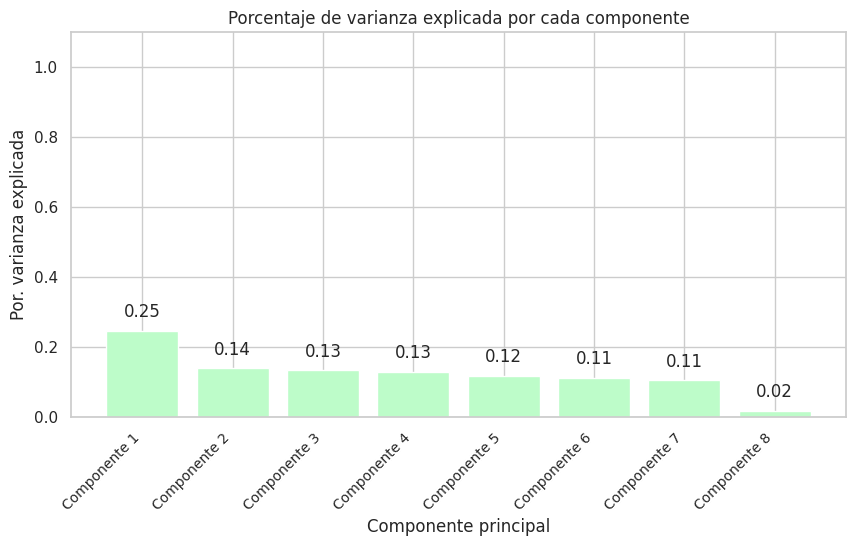

Cargas de las características en los componentes principales:
   intakereason      Raza  basecolour  speciesname  animalage   sexname  \
0     -0.078936 -0.668635    0.129914     0.659031   0.229662 -0.014140   
1      0.104742  0.005648   -0.522476     0.023455   0.119079  0.636986   
2     -0.591311  0.174201    0.189622    -0.230712   0.642547 -0.116461   
3      0.512676  0.017291    0.424542    -0.002911   0.113649 -0.236177   
4      0.409598  0.087942   -0.192148    -0.102853   0.082334 -0.378874   
5      0.257107  0.096183    0.598831    -0.093910   0.156908  0.614864   
6      0.368437 -0.003468   -0.313550    -0.001706   0.689330 -0.051733   
7      0.026310 -0.710811   -0.010772    -0.701777  -0.026798  0.020653   

   Mes_Ingreso  location  
0    -0.123702  0.165075  
1     0.262456  0.476079  
2     0.039857  0.320629  
3     0.635284  0.290412  
4    -0.597811  0.518935  
5    -0.390841 -0.042348  
6     0.015004 -0.536514  
7     0.016747 -0.004765  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Entrenar un modelo de PCA
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(xc)

# Extraer el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

# Obtener las cargas de los componentes principales
loadings = modelo_pca.components_

# Crear un DataFrame para almacenar las cargas con los nombres de las características originales
loadings_df = pd.DataFrame(loadings, columns=xc.columns)

# Porcentaje de varianza explicada por cada componente
print('Porcentaje de varianza explicada por cada componente')
print(modelo_pca.explained_variance_ratio_)

# Crea un gráfico de barras para mostrar el porcentaje de varianza explicada
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
barplot = ax.bar(x=np.arange(modelo_pca.n_components_) + 1, height=modelo_pca.explained_variance_ratio_)

# Etiqueta el eje x con los nombres de las variables
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_xticklabels(['Componente ' + str(i) for i in range(1, modelo_pca.n_components_ + 1)], fontsize=10, rotation=45, ha='right')

# Anotar los valores en el gráfico
for i, y in enumerate(modelo_pca.explained_variance_ratio_, start=1):
    label = round(y, 2)
    ax.annotate(label, (i, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Configuración del gráfico
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')

# Mostrar el gráfico
plt.show()

# Mostrar las cargas de las características en un DataFrame
print("Cargas de las características en los componentes principales:")
print(loadings_df)

In [ ]:
# Obtener las cargas de las características en el primer componente principal
cargas_componente_1 = loadings_df.iloc[0]

cargas_ordenadas_componente_1 = cargas_componente_1.abs().sort_values(ascending=False)

print("Características con las cargas más altas en el primer componente principal:")
print(cargas_ordenadas_componente_1)


Características con las cargas más altas en el primer componente principal:
Raza            0.668635
speciesname     0.659031
animalage       0.229662
location        0.165075
basecolour      0.129914
Mes_Ingreso     0.123702
intakereason    0.078936
sexname         0.014140
Name: 0, dtype: float64


In [ ]:
# Obtener las cargas de las características en el segundo componente principal
cargas_componente_2 = loadings_df.iloc[1]

cargas_ordenadas_componente_2 = cargas_componente_2.abs().sort_values(ascending=False)

print("Características con las cargas más altas en el segundo componente principal:")
print(cargas_ordenadas_componente_2)


Características con las cargas más altas en el segundo componente principal:
sexname         0.636986
basecolour      0.522476
location        0.476079
Mes_Ingreso     0.262456
animalage       0.119079
intakereason    0.104742
speciesname     0.023455
Raza            0.005648
Name: 1, dtype: float64


Podemos observar que el resultado està explicado en un 40% por los dos primeros componentes. El componente principal está altamente asociado a la raza y a la especie mientras que el segundo componente està asociado al sexo, color y ubicación. Finalmente podríamos evaluar de eliminar la variable 'intakereason' ya que tiene cargas bajas en los primeros dos componentes pero considerando que la carga no es nula y que además tenemos un modelo con pocas variables, vamos a sostener las 8 variables que tenemos.